In [32]:
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import matplotlib.pyplot as plt

def backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent):
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')

    all_data = []
    final_results = None

    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        if agent == "ddpg":
            price_lower = ddpg_action['price_lower']
            price_upper = ddpg_action['price_upper']
        else:
            price_lower = ppo_action['price_lower']
            price_upper = ppo_action['price_upper']

        response = simulate_position(X_reserve, Y_reserve, start_date_str, end_date_str, price_lower, price_upper)
        response_json = response.json()
        data_df, results_df = save_data_to_df(response_json)

        if 'LP_positions' not in response_json:
            print(f"Error: 'LP_positions' not found in response or response is None: {response_json}")
            break

        # Append the data to the all_data list
        all_data.extend(data_df.to_dict('records'))
        final_results = results_df.to_dict('records')[0]

        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)

    # Create DataFrame from all_data
    final_data_df = pd.DataFrame(all_data)
    final_results_df = pd.DataFrame([final_results])

    return final_data_df, final_results_df

def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", date_str='2024-05-05'):
    url = "http://127.0.0.1:8000/predict_action/"
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str": date_str
    }
    response = requests.post(url, json=data)
    response_json = response.json()
    ddpg_action = response_json['ddpg_action']
    ppo_action = response_json['ppo_action']
    
    return ddpg_action, ppo_action

def simulate_position(X_reserve=0.01, Y_reserve=0.18, start_date="2024-03-01 00:00:00", end_date="2024-03-29 00:00:00", lower_price=16.0, upper_price=20.0):
    vector = {
        "X": X_reserve,
        "Y": Y_reserve,
        "positions": [
            {
                "start": start_date,
                "end": end_date,
                "lower_price": lower_price,
                "upper_price": upper_price,
            },
        ]
    }
    url = "http://localhost:5050/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response

def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'curr_price':burn_data.get('burn_price')/1e10,
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left'),
            'X_mint': mint_data.get('X_mint'),
            'Y_left': mint_data.get('Y_left'),
            'Y_mint': mint_data.get('Y_mint'),
            'X_fee': burn_data.get('X_fee'),
            'X_reserve': burn_data.get('X_reserve'),
            'Y_fee': burn_data.get('Y_fee'),
            'Y_reserve': burn_data.get('Y_reserve'),
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),
            'Yield': info_data.get('Yield')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value'),
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end'),
        'final_portfolio_value_start': final_result.get('portfolio_value_start')
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df

def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.plot(data_df['start'], data_df['curr_price'], label='Current Price')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



#Usage
start_date = '01-01-24'
end_date = '29-03-24'
ddpg_agent_path = 'model_storage/ddpg/ddpg_1'
ppo_agent_path = 'model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id = "0xcbcdf9626bc03e24f779434178a73a0b4bad62ed"
agent = "ddpg"
X_reserve = 2
Y_reserve = 10
rebalancing_frequency = 7

data_df, results_df = backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent)
# Plotting the results

{"LP_positions":[{"burn":{"X_collect":178727316,"X_fee":104677,"X_reserve":178622639,"Y_collect":14129076470437220735,"Y_fee":33659229967493371,"Y_reserve":14095417240469727364,"burn_price":197535436473.07245,"sqrtPriceX96":35212924205261462429068416241584052},"info":{"APR":-7.692071448274949,"Impermanent_loss":0.25727446769335977,"PnL":-0.14751917846006754,"X_start":2,"X_start_wei":200000000,"Y_start":10,"Y_start_wei":10000000000000000000,"Yield":0.10975528923329743,"duration":604800.0,"end":"2024-01-08 00:00:00","lower_price":16.011589631658186,"start":"2024-01-01 00:00:00","upper_price":35.21672000161635},"mint":{"X_left":24862,"X_mint":202102334,"Y_left":180435704,"Y_mint":9604939469429175329,"liquidity":317496546662132,"lower_nearest_tick":258000,"pool_price":185163423450.05405,"pool_tick":260104,"upper_nearest_tick":265860},"swap":{"X_after_swap":202127196,"X_swap":-2127196,"Y_after_swap":9604939469609611033,"Y_swap":393878893709261184,"fee_paid":1181636681127783,"sqrtPriceX96":3

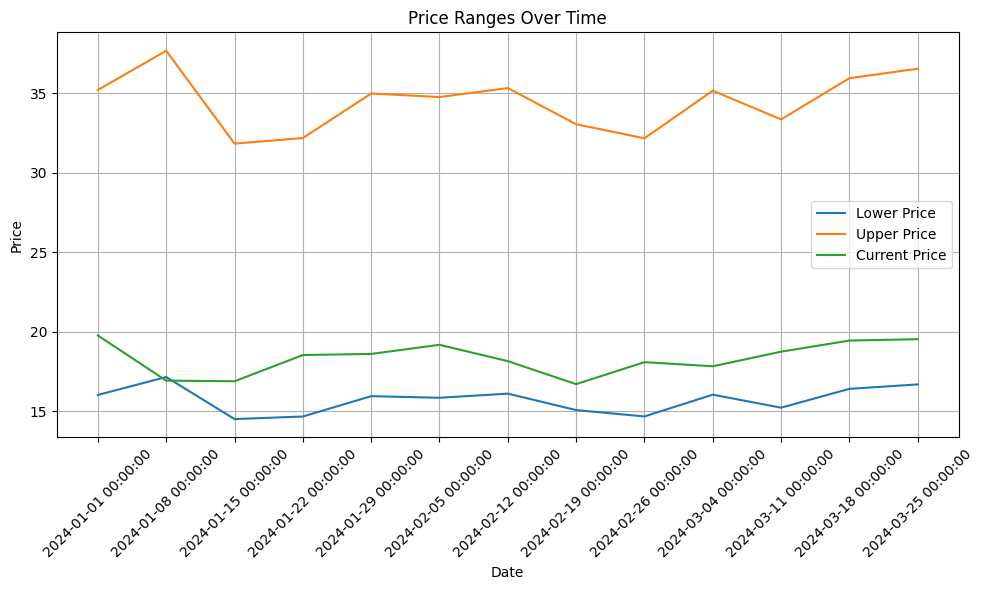

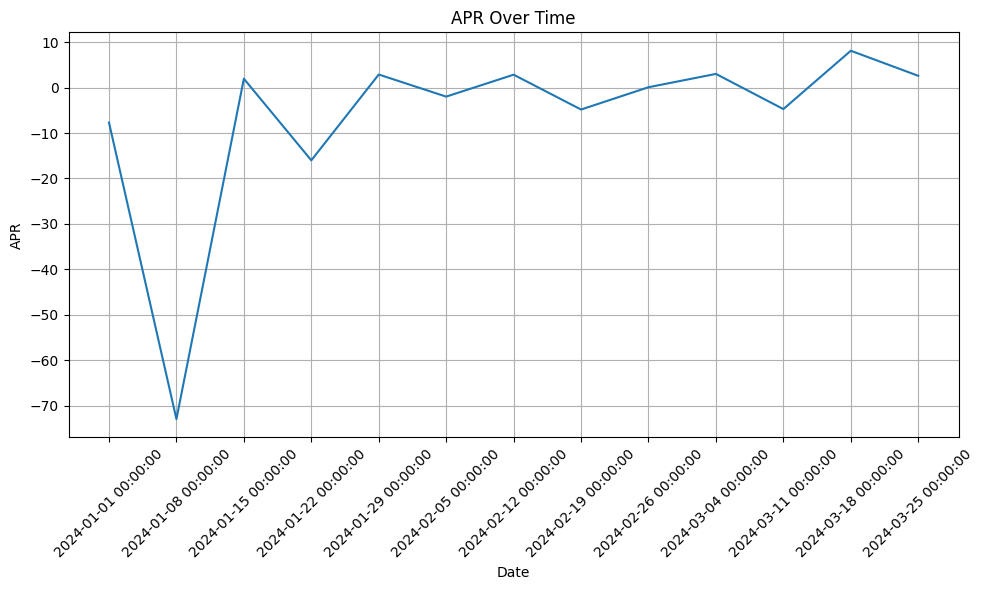

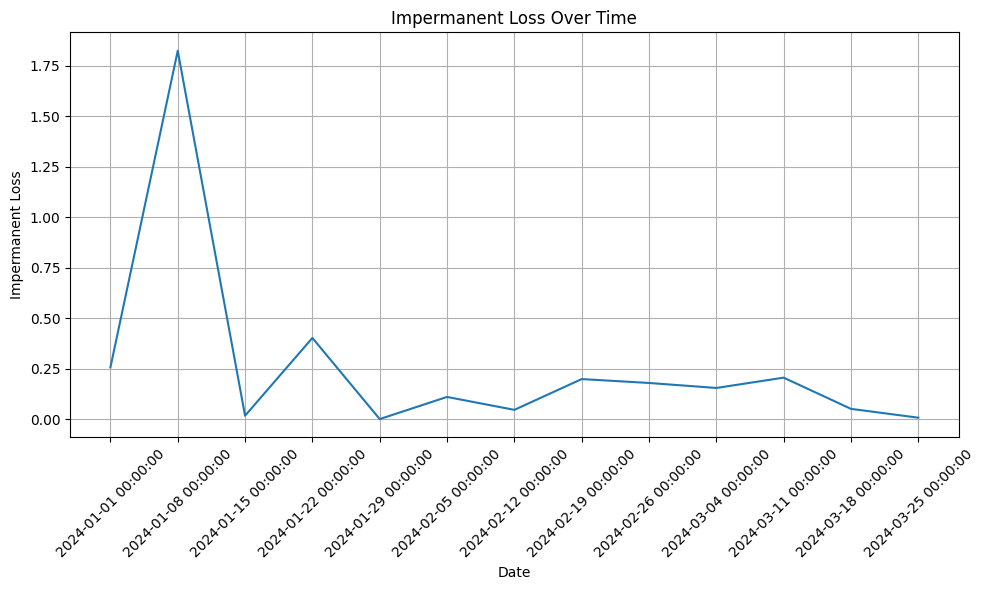

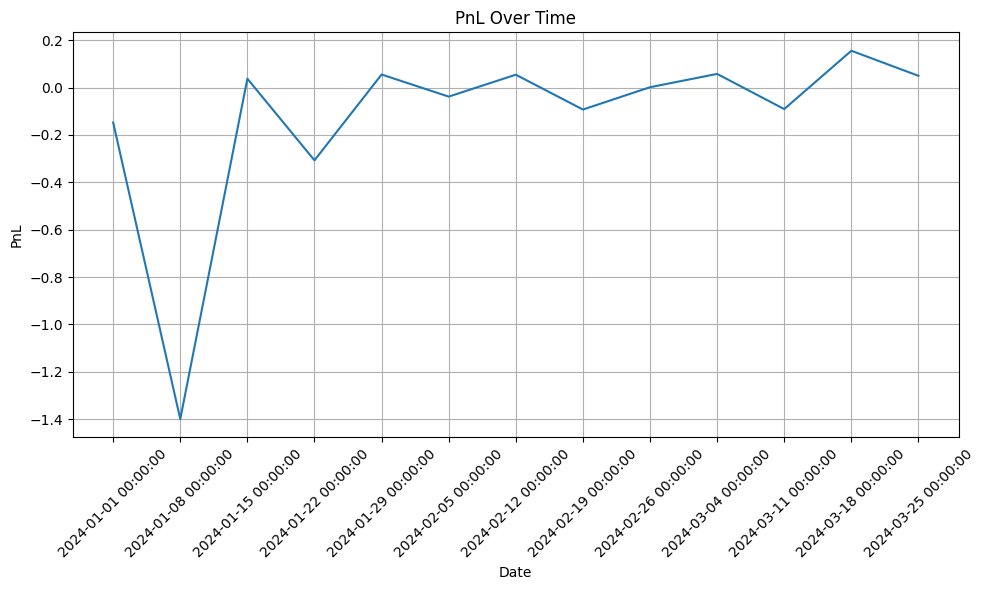

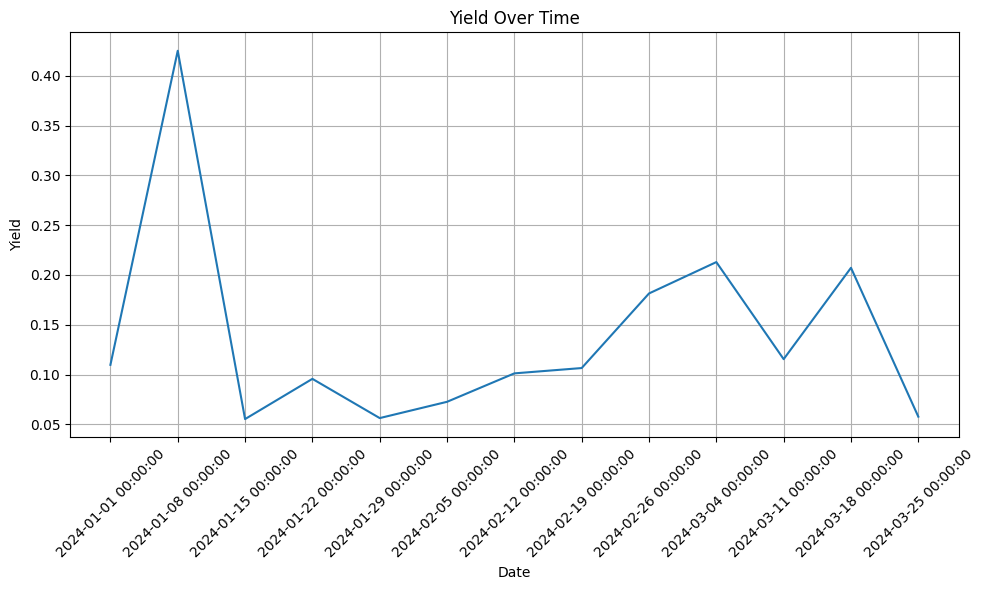

In [33]:
plot_prices_over_time(data_df)
plot_apr_over_time(data_df)
plot_il_over_time(data_df)
plot_pnl_over_time(data_df)
plot_yield_over_time(data_df)

In [35]:
results_df['final_fee_yield']-results_df['final_impermanent_loss']

0    0.049794
dtype: float64

In [37]:
results_df['final_portfolio_value_end']-results_df['final_portfolio_value_start']

0   -3.895052e+15
dtype: float64